![tutorial banner](images/PVLib_PVPMCLogo.PNG)


# Tutorial 2 - Modeling POA from GHI, DHI, and DNI

This notebook shows how to use pvlib to transform the three irradiance components (GHI, DHI, and DNI) into POA irradiance, the main driver of a PV system.

![Overview](images/tutorial_2_overview.PNG)


## Steps:

<ol>
    <li><a id='step1'>Calculating Solar Position</a></li>
    <li><a id='step2'>Fixed Tilt POA </a></li>
    <li><a id='step3'>Modeling POA for a tracking system</a></li>
</ol>

### PV Concepts
- Plane of Array Irradiance
- Angle of Incidence
- Time delta for solar position
- GHI vs POA for fixed tilt system and tracked systems

### Python Concepts
- pandas Timedelta
- making a new dataframe from existing columns
- resampling
- bar ploting

### What is transposition?

The amount of sunlight collected by a PV panel depends on how well the panel orientation matches incoming sunlight.  For example, a rooftop array facing West will produce hardly any energy in the morning when the sun is in the East because the panel can only "see" the dim part of the sky away from the sun.  

![Overview](images/t2_solarpanel_directions.PNG)


As the sun comes into view and moves towards the center of the panel's field of view, the panel will collect more and more irradiance.  This concept is what defines plane-of-array irradiance -- the amount of sunlight available to be collected at a given panel orientation.  Like the three "basic" irradiance components, POA irradiance is measured in watts per square meter.



Each irradiance component is considered separately when modeling POA irradiance.  For example, calculating the component of direct irradiance (DNI) that is incident on a panel is solved with straightforward geometry based on the angle of incidence.  Finding the POA component of diffuse irradiance (DHI) is more complex and can vary based on atmospheric conditions.  Many models, ranging from simple models with lots of assumptions to strongly empirical models, have been published to transpose DHI into the diffuse POA component.  A third component of POA irradiance is light that reflects off the ground before being collected by the PV panel.  Functions to calculate each of these components are provided by pvlib.


![Overview](images/t2_POA.PNG)

### How is array orientation defined?

Two parameters define the panel orientation, one that measures the cardinal direction (North, East, South, West), and one that measures how high in the sky the panel faces:

- tilt; measured in degrees from horizontal.  A flat panel is at tilt=0 and a panel standing on its edge has tilt=90.
- azimuth; measured in degrees from North.  The direction along the horizon the panel is facing.  N=0, E=90, S=180, W=270.

A fixed array has fixed tilt and azimuth, but a tracker array constantly changes its orientation to best match the sun's position.  So depending on the system configuration, tilt and azimuth may or may not be time series values.



In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install -r https://raw.githubusercontent.com/PVSC-Python-Tutorials/PVPMC_2022/main/requirements.txt

<a href='#step1'>

## 1. Calculating Solar Position

As mentioned earlier, pvlib makes it easy to calculate POA irradiance.  First, let's load in the example TMY dataset from the previous tutorial:

In [2]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

print(pvlib.__version__)

DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

# make a Location object corresponding to this TMY
location = pvlib.location.Location(latitude=metadata['latitude'],
                                   longitude=metadata['longitude'])

0.9.4


In [3]:
print("We are looking at data from ", metadata['Name'], ",", metadata['State'])

We are looking at data from  "GREENSBORO PIEDMONT TRIAD INT" , NC


Because part of the transposition process requires knowing where the sun is in the sky, let's use pvlib to calculate solar position.  There is a gotcha here!  TMY data represents the average weather conditions across each hour, meaning we need to calculate solar position in the middle of each hour.  pvlib calculates solar position for the exact timestamps you specify, so we need to adjust the times by half an interval (30 minutes):

In [4]:
# Note: TMY datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
solar_position.index += pd.Timedelta('30min')

solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
1990-01-01 01:00:00-05:00,166.841893,166.841893,-76.841893,-76.841893,6.889661,-3.395097
1990-01-01 02:00:00-05:00,160.512529,160.512529,-70.512529,-70.512529,52.424214,-3.414863
1990-01-01 03:00:00-05:00,149.674856,149.674856,-59.674856,-59.674856,73.251821,-3.434619
1990-01-01 04:00:00-05:00,137.777090,137.777090,-47.777090,-47.777090,85.208599,-3.454365
1990-01-01 05:00:00-05:00,125.672180,125.672180,-35.672180,-35.672180,94.134730,-3.474102


The two values needed here are the solar zenith (how close the sun is to overhead) and azimuth (what direction along the horizon the sun is, like panel azimuth).  The difference between `apparent_zenith` and `zenith` is that `apparent_zenith` includes the effect of atmospheric refraction.

Now that we have a time series of solar position that matches our irradiance data, let's run a transposition model using the convenient wrapper function [`pvlib.irradiance.get_total_irradiance`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.irradiance.get_total_irradiance.html). The more complex transposition models like Perez and Hay Davies require additional weather inputs, so for simplicity we'll just use the basic `isotropic` model here, which is the default if nothing is passed for `model` keyword argument.  As an example, we'll model a fixed array tilted south at 20 degrees.

<a href='#step2'>

## 2. Fixed Tilt POA

In [5]:
df_poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=20,  # tilted 20 degrees from horizontal
    surface_azimuth=180,  # facing South
    dni=df_tmy['DNI'],
    ghi=df_tmy['GHI'],
    dhi=df_tmy['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic')

`get_total_irradiance` returns a DataFrame containing each of the POA components mentioned earlier (direct, diffuse, and ground), along with the total in-plane irradiance.  

In [6]:
df_poa.keys()

Index(['poa_global', 'poa_direct', 'poa_diffuse', 'poa_sky_diffuse',
       'poa_ground_diffuse'],
      dtype='object')

### What angle should you tilt your modules at?

[PVEducation Solar Radiation on a Tilted Surface](https://www.pveducation.org/pvcdrom/properties-of-sunlight/solar-radiation-on-a-tilted-surface)

The total POA irradiance is called `poa_global` and is the one we'll focus on. Like the previous tutorial, let's visualize monthly irradiance to summarize the difference between the insolation received by a flat panel (GHI) and that of a tilted panel (POA):

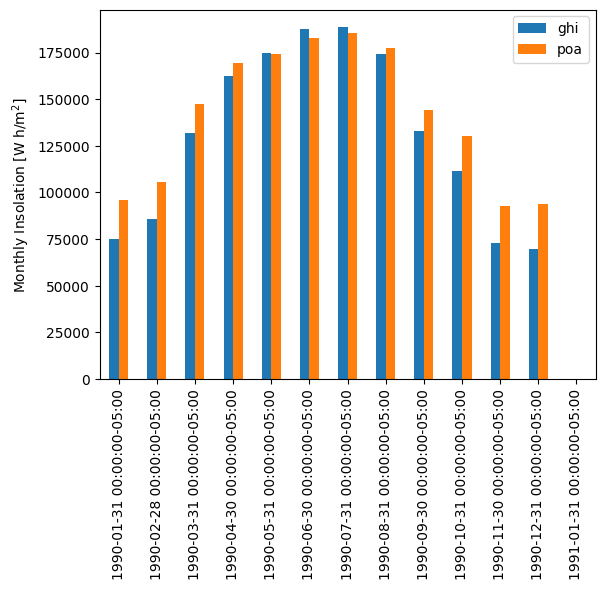

In [7]:
df = pd.DataFrame({
    'ghi': df_tmy['GHI'],
    'poa': df_poa['poa_global'],
})
df_monthly = df.resample('M').sum()
df_monthly.plot.bar()
plt.ylabel('Monthly Insolation [W h/m$^2$]');

This plot shows that, compared with a flat array, a tilted array receives significantly more insolation in the winter.  However, it comes at the cost of slightly less insolation in the summer.  The difference is all about solar position -- tilting up from horizontal gives a better match to solar position in winter, when the sun is low in the sky.  However it gives a slightly worse match in summer when the sun is very high in the sky.

As an example, here's a sunny day in winter vs a sunny day in summer.  Note that the daily profile doesn't just change its height, it also changes its width (summer POA is "skinnier" than GHI).

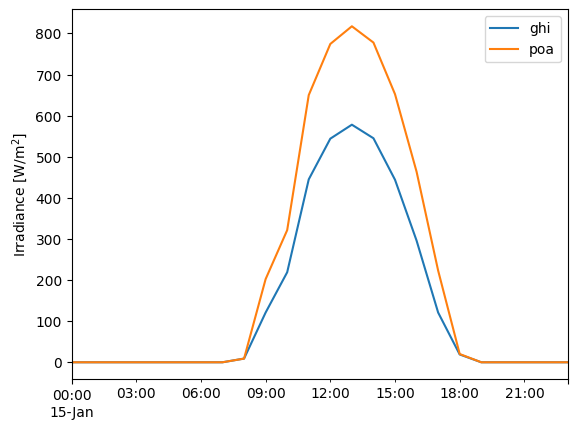

In [8]:
df.loc['1990-01-15'].plot()
plt.ylabel('Irradiance [W/m$^2$]');

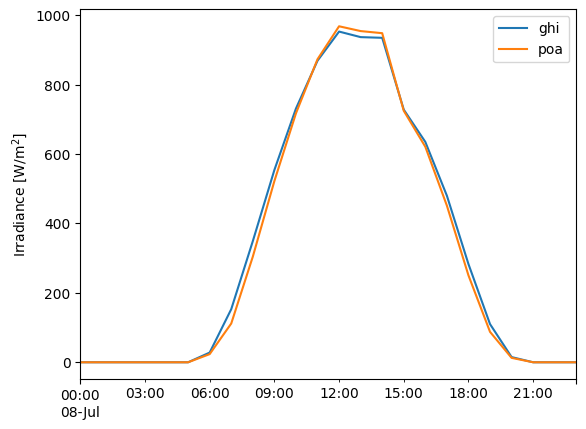

In [9]:
df.loc['1990-07-08'].plot()
plt.ylabel('Irradiance [W/m$^2$]');

The difference between GHI and POA is of course dependent on the tilt defining POA, but because it also depends on solar position, it varies from location to location.  Luckily, tools like pvlib make it easy to model!


<a href='#step3'>

## 3. Modeling POA for a tracking system

The previous section calculated the transposition assuming a fixed array tilt and azimuth.  Now we'll do the same for a tracking array that follows the sun across the sky.  The most common type of tracking array is what's called a single-axis tracker (SAT) that rotates from East to West to follow the sun.  We can calculate the time-dependent orientation of a SAT array with pvlib:

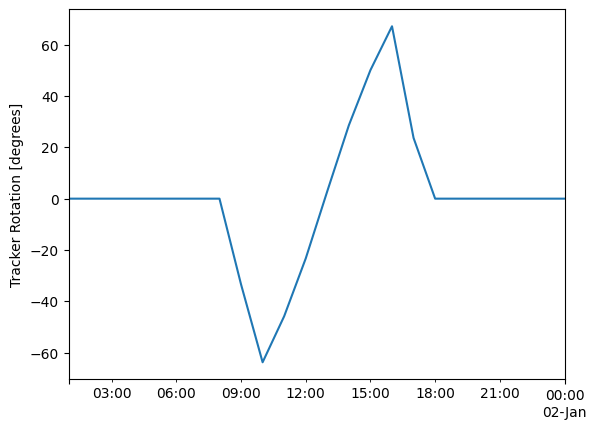

In [10]:
tracker_data = pvlib.tracking.singleaxis(
    solar_position['apparent_zenith'],
    solar_position['azimuth'],
    axis_azimuth=180,  # axis is aligned N-S
    )  # leave the rest of the singleaxis parameters like backtrack and gcr at their defaults
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

# plot a day to illustrate:
tracker_data['tracker_theta'].fillna(0).head(24).plot()
plt.ylabel('Tracker Rotation [degrees]');

This plot shows a single day of tracker operation.  The y-axis shows the tracker rotation from horizontal, so 0 degrees means the panels are flat.  In the morning, the trackers rotate to negative angles to face East towards the morning sun; in the afternoon they rotate to positive angles to face West towards the evening sun.  In the middle of the day, the trackers are flat because the sun is more or less overhead.

Now we can model the irradiance collected by a tracking array -- we follow the same procedure as before, but using the timeseries tilt and azimuth this time:

In [11]:
df_poa_tracker = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tilt,  # time series for tracking array
    surface_azimuth=azimuth,  # time series for tracking array
    dni=df_tmy['DNI'],
    ghi=df_tmy['GHI'],
    dhi=df_tmy['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

Like before, let's compare GHI and POA:

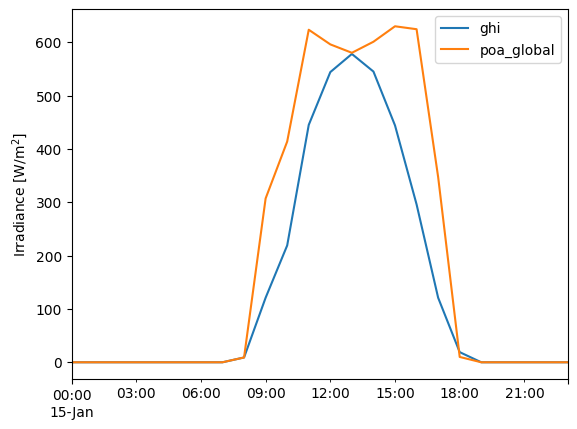

In [12]:
df.loc['1990-01-15', 'ghi'].plot()
tracker_poa.loc['1990-01-15'].plot()
plt.legend()
plt.ylabel('Irradiance [W/m$^2$]');

Notice how different the daily profile is for the tracker array!  This is because the array can tilt steeply East and West to face towards the sun in early morning and late afternoon, meaning the edges of day get much higher irradiance than for a south-facing array.

Note also that in the middle of the day, GHI and POA just touch each other -- this is because at solar noon, the array lies flat, and so POA is momentarily identical to GHI.

Note that the POA calculations discussed above do not address the partial blocking of diffuse light in arrays with multiple tilted rows of PV modules, so the results will be slightly (typically 1-3%) optimistic relative to real conditions or to commercial modeling software. Such corrections are likely to be added to pvlib in the future for specific generic geometries like fixed racks.

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).